In [207]:
from SimPEG import EM, Mesh, Utils, Maps
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
%matplotlib inline
import matplotlib 
matplotlib.rcParams["font.size"] = 14
matplotlib.rcParams["image.cmap"] = "jet"

In [332]:
# !cp SteadyState_ISIP.ipynb /Users/sgkang/Dropbox/PhD/numerical_examples/discussion

In [208]:
figdir = "/Users/sgkang/Dropbox/PhD/diissertation/figures/discussion/"

In [209]:
# eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 10., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.005
airind = mesh.gridCC[:,2]>0.
sigmaInf[airind] = 1e-8

In [279]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
dt = 2e-3
rx_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+dt, 'z')
src_ramp = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=dt), loc=srcloc)
survey_ramp = EM.TDEM.Survey([src_ramp])
prb_em_ramp = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
# prb_em_ramp.verbose = True
prb_em_ramp.timeSteps = [(dt/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_ramp.Solver = PardisoSolver
prb_em_ramp.pair(survey_ramp)
# m = np.r_[sigmaInf, etavec, np.log(tauvec), cvec]
F_ramp = prb_em_ramp.fields(sigmaInf)
data_ramp = survey_ramp.dpred(sigmaInf, f=F_ramp)
cur = []
for t in prb_em_ramp.times:
    cur.append(src_ramp.waveform.eval(t))
cur = np.hstack(cur)

In [223]:
from simpegEMIP.TDEM import geteref

In [253]:
x = np.r_[10, 80., 250]
y = -x * np.tan(np.deg2rad(30.))

In [256]:
rxinds = Utils.closestPoints(mesh, np.c_[x, np.zeros_like(x), y], gridLoc="N")

In [241]:
from simpegem1d import EM1DAnal

In [242]:
EM1DAnal.DiffusionDistnace(1.5e-3, 0.005)

690.98829894267101

In [243]:
t1, t2, t3 = 2*1e-3, 2*1e-3 + 1e-5, 2*1e-3 + 1e-4
ind1 = np.argmin(abs(prb_em_ramp.times-t1))
ind2 = np.argmin(abs(prb_em_ramp.times-t2))
ind3 = np.argmin(abs(prb_em_ramp.times-t3))

10
17
31


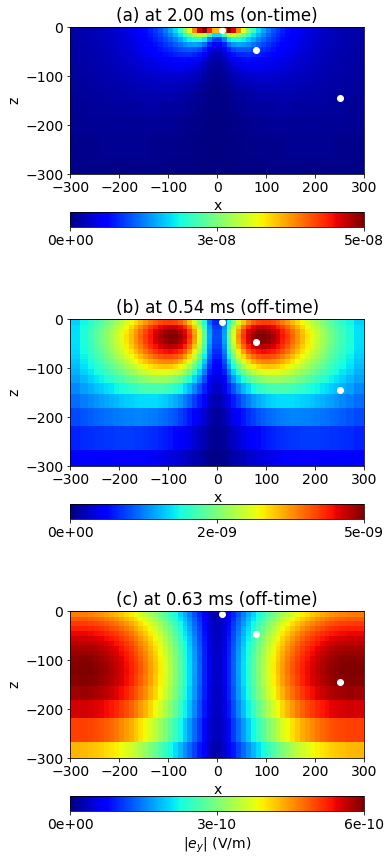

In [275]:
fig, ax  = plt.subplots(3, 1, figsize = (5.5,12.7))
for i, tind in enumerate([ind1, ind2, ind3]):
    temp = mesh.aveE2CCV*F_ramp[src_ramp,'eSolution', tind]
    temp[airind] = 0.
    print tind
    vmin, vmax = temp.min()*0., temp.max()
    dat = mesh.plotImage(temp, grid=False, mirror=True, ax=ax[i])
    cb = plt.colorbar(dat[0], orientation="horizontal", format="%.0e", ticks=np.linspace(vmin, vmax,3), ax=ax[i])
    ax[i].set_xlim(-300, 300)
    ax[i].set_ylim(-300, 0)
    ax[i].set_aspect('equal')
    ax[i].plot(x, y, 'wo')
    if i==2:
        cb.set_label("$|e_y|$ (V/m)")
ax[0].set_title(("(a) at %1.2f ms (on-time)") % (prb_em_ramp.times[ind1]*1e3))
ax[1].set_title(("(b) at %1.2f ms (off-time)")% (prb_em_ramp.times[ind2]*1e3-1.47))
ax[2].set_title(("(c) at %1.2f ms (off-time)")% (prb_em_ramp.times[ind3]*1e3-1.47))
plt.tight_layout()
fig.savefig(figdir + "e_field_ramp_off", dpi =300)

In [321]:
time_temp = np.arange(101) * 0.03
e_prim = np.zeros_like(time_temp)
e_prim[time_temp<2] = 1.
e_prim[0] = 0.

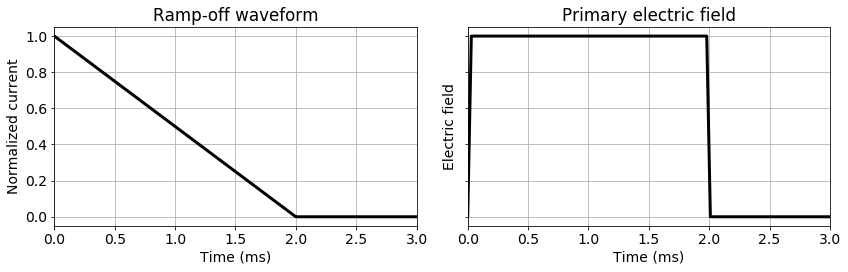

In [329]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].plot(prb_em_ramp.times*1e3, cur, 'k', lw=3)
ax[0].set_ylabel("Normalized current")
ax[1].set_ylabel("Electric field")
ax[1].plot(time_temp, e_prim, 'k', lw=3)
for i in range(2):
    ax[i].set_xlabel('Time (ms)')
    ax[i].grid(True)
    ax[i].set_xlim(0, 3)
    ax[i].set_xlabel('Time (ms)')
ax[0].set_title("Ramp-off waveform")
ax[1].set_title("Primary electric field")
ax[1].set_yticklabels([])
plt.tight_layout()
fig.savefig(figdir+"ramp_off_wave", dpi=300)

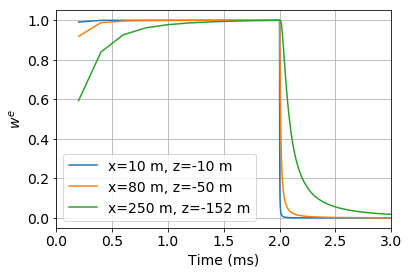

In [295]:
fig = plt.figure()
e = F_ramp[src_ramp,'eSolution', :]
eref_ramp = geteref(F_ramp[src_ramp, 'eSolution', :], mesh, option=None, tInd=10) 
# z = mesh.vectorCCz[np.logical_and(mesh.vectorCCz < 0., mesh.vectorCCz > -300.)]
# x = mesh.vectorCCx[mesh.vectorCCx < 300.]
# xyz = Utils.ndgrid(x, np.r_[0.], z)
# rxinds = Utils.closestPoints(mesh, pts=xyz, gridLoc='N')
legend = []
for rxind in rxinds:
    plt.plot(prb_em_ramp.times[1:]*1e3, e[rxind,1:].flatten() / eref_ramp[rxind])
    legend.append(("x=%.0f m, z=%.0f m")%(mesh.gridN[rxind,0], mesh.gridN[rxind,2]))
plt.legend(legend)
plt.xscale('linear')
plt.xlabel('Time (ms)')
plt.ylabel('$w^e$')
plt.grid(True)
plt.xlim(0, 3)
fig.savefig(figdir + "we_ramp_off", dpi=300)